In [1]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014,119
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014,89
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014,90
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981,61


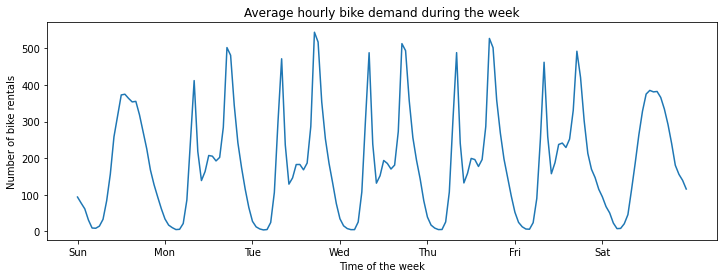

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

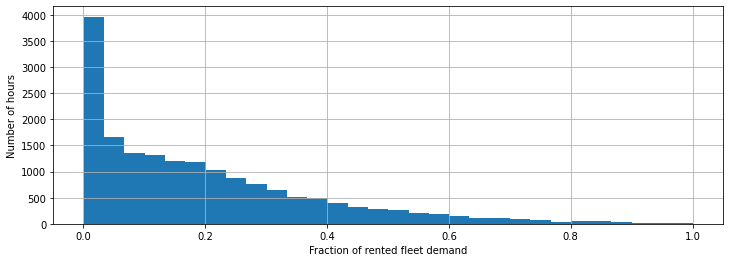

In [3]:
y = df["count"] / df["count"].max()
fig, ax = plt.subplots(figsize=(12, 4))
y.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

In [4]:
X = df.drop("count", axis="columns")
X


,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


In [5]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

all_splits = list(ts_cv.split(X, y))

In [6]:
train_0, test_0 = all_splits[0]

In [7]:
train_0.shape

(10000,)

In [8]:
test_0.shape

(1000,)

In [9]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

# Gradient Boosting

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate


categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]

categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

In [11]:
ordinal_encoder.fit_transform(df[categorical_columns])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [12]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("categorical", ordinal_encoder, categorical_columns)
        ],
        remainder = "passthrough", verbose_feature_names_out = False
    ),
    HistGradientBoostingRegressor(
        categorical_features = categorical_columns
    )
).set_output(transform = "pandas")


In [13]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model, X, y, cv = cv,
        scoring = ["neg_mean_absolute_error", "neg_root_mean_squared_error"]
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

evaluate(gbrt_pipeline, X, y, cv = ts_cv)

Mean Absolute Error:     0.044 +/- 0.003
Root Mean Squared Error: 0.068 +/- 0.005


# Naive linear regresssion

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
import numpy as np


one_hot_encoder = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
alphas = np.logspace(-6, 6, 25)

naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder = MinMaxScaler()
    ),
    RidgeCV(alphas = alphas)
)

evaluate(naive_linear_pipeline, X, y, cv = ts_cv)

Mean Absolute Error:     0.142 +/- 0.014
Root Mean Squared Error: 0.184 +/- 0.020


In [15]:
c = ColumnTransformer(
        transformers = [
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder = MinMaxScaler()
    )

c.fit_transform(X)

array([[1.        , 0.        , 0.        , ..., 0.2879    , 0.81      ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.2727    , 0.8       ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.2727    , 0.8       ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.2576    , 0.6       ,
        0.19301751],
       [1.        , 0.        , 0.        , ..., 0.2727    , 0.56      ,
        0.15786999],
       [1.        , 0.        , 0.        , ..., 0.2727    , 0.65      ,
        0.15786999]])

# Trigonometric features

In [16]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x : np.sin(x / period*2*np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x : np.cos(x / period*2*np.pi))

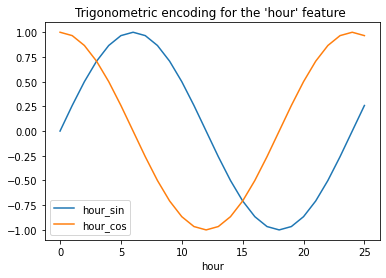

In [17]:
import pandas as pd

hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns = ["hour"]
)

hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]

hour_df.plot(x = "hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature ")

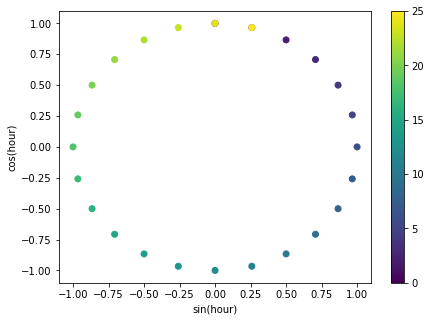

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

In [19]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers = [
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"])
    ],
    remainder = MinMaxScaler()
)

cyclic_cossin_transformer_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas)
)

evaluate(cyclic_cossin_transformer_pipeline, X, y, cv = ts_cv)

Mean Absolute Error:     0.125 +/- 0.014
Root Mean Squared Error: 0.166 +/- 0.020


In [24]:
df_cycle = cyclic_cossin_transformer.fit_transform(df)
df_cycle.shape

(17379, 23)

In [23]:
X.shape

(17379, 12)

In [28]:
X = X[["season", "month", "weekday", "hour"]]


categorical_columns = [
    "season"
]

categories = [
    ["spring", "summer", "fall", "winter"]
]

ordinal_encoder = OrdinalEncoder(categories=categories)

In [35]:
trans_1 = ColumnTransformer(
        transformers = [
            ("categorical", ordinal_encoder, categorical_columns),
            ("month_sin", sin_transformer(12), ["month"]),
            ("month_cos", cos_transformer(12), ["month"]),
            ("weekday_sin", sin_transformer(7), ["weekday"]),
            ("weekday_cos", cos_transformer(7), ["weekday"]),
            ("hour_sin", sin_transformer(24), ["hour"]),
            ("hour_cos", cos_transformer(24), ["hour"])
        ],
        remainder = MinMaxScaler()
    )

dd = trans_1.fit_transform(X)
pd.DataFrame(dd)

,0,1,2,3,4,5,6
0,0.0,5.000000e-01,0.866025,-0.781831,0.62349,0.000000,1.000000
1,0.0,5.000000e-01,0.866025,-0.781831,0.62349,0.258819,0.965926
2,0.0,5.000000e-01,0.866025,-0.781831,0.62349,0.500000,0.866025
3,0.0,5.000000e-01,0.866025,-0.781831,0.62349,0.707107,0.707107
4,0.0,5.000000e-01,0.866025,-0.781831,0.62349,0.866025,0.500000
...,...,...,...,...,...,...,...
17374,0.0,-2.449294e-16,1.000000,0.781831,0.62349,-0.965926,0.258819
17375,0.0,-2.449294e-16,1.000000,0.781831,0.62349,-0.866025,0.500000
17376,0.0,-2.449294e-16,1.000000,0.781831,0.62349,-0.707107,0.707107
17377,0.0,-2.449294e-16,1.000000,0.781831,0.62349,-0.500000,0.866025


In [36]:
trans_1.feature_names_in_

array(['season', 'month', 'weekday', 'hour'], dtype=object)